### Import dependencies

In [1]:
from Bio import SeqIO
import re
import csv
import pandas as pd

### Parse the file with GenBank records

In [2]:
file_path = '../data/sequence.gb'
genbank_records = SeqIO.parse(file_path, 'gb')
genbank_records = list(genbank_records)

### Create empty lists for storing qualifier information

In [3]:
hosts = []
collection_dates = []
countries = []
isolation_sources = []
isolates = []
strains = []
serotypes = []
record_ids = []
references = []
number_of_records = 0
CDS_count = 0

In [4]:
"""
The function checks if the qualifier is a list and returns the appropriate value.
If the qualifier is a list, its first element is returned.
If the qualifier is not a list, it is returned as is.
If the qualifier is not found by the key, the string 'Unknown' is returned. 
"""
def parse_qualifier(qualifier, key):
    value = qualifier.get(key, 'Unknown')
    return value if not isinstance(value, list) else value[0]

def merge_values(values):
    for value in values:
        if value != 'Unknown':
            return value
    return 'Unknown'

def extract_data_from_record(record):
    features = record.features
    source_feature_list = [feature for feature in features if feature.type == 'source']

    merged_values = {
        'host': [],
        'collection_date': [],
        'geo_loc_name': [],
        'isolation_source': [],
        'isolate': [],
        'strain': [],
        'organism': []
    }

    for source_feature in source_feature_list:
        qual_dict = source_feature.qualifiers

        for key in merged_values.keys():
            merged_values[key].append(parse_qualifier(qual_dict, key))

    hosts.append(merge_values(merged_values['host']))
    collection_dates.append(merge_values(merged_values['collection_date']))
    countries.append(merge_values(merged_values['geo_loc_name']))
    isolation_sources.append(merge_values(merged_values['isolation_source']))
    isolates.append(merge_values(merged_values['isolate']))
    strains.append(merge_values(merged_values['strain']))
    serotypes.append(merge_values(merged_values['organism']))

    for reference in record.annotations["references"]:
        references.append(reference.title)
        break
 
    record_ids.append(record.name)

for record in genbank_records:
    extract_data_from_record(record)
    CDS_count += sum(1 for feature in record.features if feature.type == 'CDS')
    number_of_records += 1

print("Number of records:", number_of_records)
print("Number of CDS:", CDS_count)
print("Hosts:", hosts[:5])
print("Collection Dates:", collection_dates[:5])
print("Countries:", countries[:5])
print("Isolation Sources:", isolation_sources[:5])
print("Isolates:", isolates[:5])
print("Strains:", strains[:5])
print("Serotypes:", serotypes[:5])
print("Record IDs:", record_ids[:5])


Number of records: 446
Number of CDS: 439
Hosts: ['Sus scrofa (domestic pig)', 'Sus scrofa', 'domestic pig', 'Coracias garrulus (European roller)', 'Bos taurus']
Collection Dates: ['2007', '2018', '2013', 'Jul-2011', '07-Oct-2015']
Countries: ['Hungary', 'Germany', 'China', 'Hungary', 'Viet Nam']
Isolation Sources: ['feces', 'nasal swab', 'fecal sample', 'fecal sample', 'rectal swab']
Isolates: ['Unknown', 'Unknown', 'Unknown', 'Unknown', 'mt22vf_Cow']
Strains: ['swine/S-1-HUN/2007/Hungary', 'FoPro-213.14/GER/2018', 'JS-01-CHN/2013/China', 'SZAL6-KoV/2011/HUN', 'Unknown']
Serotypes: ['Porcine kobuvirus swine/S-1-HUN/2007/Hungary', 'Porcine kobuvirus', 'Porcine kobuvirus JS-01-CHN/2013/China', 'aichivirus A5', 'Kobuvirus sp.']
Record IDs: ['NC_011829', 'MZ334483', 'KP144318', 'KJ934637', 'PP930198']


In [5]:
# Function for reading map.csv files
def read_csv(file_name):
    with open(file_name) as csvfile:
        reader = csv.DictReader(csvfile,
                                delimiter=",", 
                                fieldnames=["base", "new"])
        result = {}
        
        for row in reader:
            base_value = row["base"].strip()
            new_value = row["new"].strip().rstrip(';')
            result[base_value] = new_value
        csvfile.close()
        return result

In [6]:
# The function maps values from a list to values in a CSV file.
def map_qualifiers(qualifier, csv_file):
    data_dict = read_csv(csv_file)
    feature_map_comp = [(re.compile(key), value) for key, value in data_dict.items()]
    mapped_values = []
    for name in qualifier:
        for regex, new_name in feature_map_comp:
            match = regex.search(name)
            if match:
                mapped_values.append(new_name)
                break
        else:
            mapped_values.append(name)
    return mapped_values

In [7]:
# Function for reading map.csv files
def read_csv_kobu(file_name):
    with open(file_name) as csvfile:
        reader = csv.DictReader(csvfile,
                                delimiter=";", 
                                fieldnames=["base", "new"])
        result = {}
        
        for row in reader:
            base_value = row["base"].strip()
            new_value = row["new"].strip()
            result[base_value] = new_value
        csvfile.close()
        return result

In [8]:
# The function maps values from a list to values in a CSV file.
def map_qualifiers_kobu(qualifier, csv_file):
    data_dict = read_csv_kobu(csv_file)
    feature_map_comp = [(re.compile(key), value) for key, value in data_dict.items()]
    mapped_values = []
    for name in qualifier:
        for regex, new_name in feature_map_comp:
            match = regex.search(name)
            if match:
                mapped_values.append(new_name)
                break
        else:
            mapped_values.append(name)
    return mapped_values

In [9]:
# Mapping hosts
hosts_mapped = map_qualifiers(hosts, '../data/tables_and_maps/host_map.csv')

# Mapping countries
countries_mapped = map_qualifiers(countries, '../data/tables_and_maps/country_map.csv')

#Mapping types
serotypes_mapped = map_qualifiers_kobu(serotypes, '../data/tables_and_maps/kobu_map.csv')

# Converting all dates to years
collection_years = ['Unknown' if date == 'Unknown' else (date[-4:] if date[-4:].isdigit() else date[:4]) for date in collection_dates]

In [10]:
# The function prints unique values and their count in the list
def print_sorted_counts(items):
    count_dict = {}
    for item in items:    
        count_dict[item] = count_dict.get(item, 0) + 1
    
    for key, value in sorted(count_dict.items(), key=lambda x: x[1], reverse=True):
        print(f"{key}: {value}")

### Save qualifier values to a table

In [11]:
df = pd.DataFrame({
    'GenBankAccession': record_ids,
    'Country': countries,
    'Host': hosts,
    'CollectionDate': collection_years,
    'Serotype': serotypes,
    'Strain': strains,
    'Isolate': isolates,
    'IsolationSource': isolation_sources
})
#df.to_csv('../metadata.csv', index=False)

### Save mapped qualifier values to a table

In [12]:
df = pd.DataFrame({
    'GenBankAccession': record_ids,
    'Country': countries_mapped,
    'Host': hosts_mapped,
    'CollectionDate': collection_years,
    'Serotype': serotypes_mapped,
    'Strain': strains,
    'Isolate': isolates,
    'IsolationSource': isolation_sources
})
#df.to_csv('../metadata_mapped.csv', index=False)

In [13]:
# Read file with sources to remove
def read_exclusion_criteria(file_name):
    with open(file_name, 'r') as file:
        exclusion_criteria = [line.strip() for line in file]
    return exclusion_criteria

### The function excludes genbank records based on isolation source and reference exclusion criterias

In [14]:
def filter_records(genbank_records, isolation_exclusion_file, reference_exclusion_file, output_file):
    isolation_exclusion_criteria = read_exclusion_criteria(isolation_exclusion_file)
    reference_exclusion_criteria = read_exclusion_criteria(reference_exclusion_file)

    filtered_records = [record for i, record in enumerate(genbank_records)
                        if not any(re.search(criteria, isolation_sources[i]) for criteria in isolation_exclusion_criteria)
                        and not any(re.search(criteria, references[i]) for criteria in reference_exclusion_criteria)]

    with open(output_file, 'w') as genbank_file:
        SeqIO.write(filtered_records, genbank_file, 'gb')

### Save filtered records

In [15]:
filter_records(genbank_records, '../data/tables_and_maps/isolation_sources_to_remove.txt', '../data/tables_and_maps/references_to_remove.txt', '../filtered_gb_records.gb')

In [16]:
filtered_hosts = []
filtered_collection_dates = []
filtered_countries = []
filtered_isolation_sources = []
filtered_isolates = []
filtered_strains = []
filtered_serotypes = []
filtered_record_ids = []
filtered_references = []

In [17]:
def extract_data_from_filtered_record(record):
    features = record.features
    source_feature_list = [feature for feature in features if feature.type == 'source']

    merged_values = {
        'host': [],
        'collection_date': [],
        'geo_loc_name': [],
        'isolation_source': [],
        'isolate': [],
        'strain': [],
        'organism': []
    }

    for source_feature in source_feature_list:
        qual_dict = source_feature.qualifiers

        for key in merged_values.keys():
            merged_values[key].append(parse_qualifier(qual_dict, key))

    filtered_hosts.append(merge_values(merged_values['host']))
    filtered_collection_dates.append(merge_values(merged_values['collection_date']))
    filtered_countries.append(merge_values(merged_values['geo_loc_name']))
    filtered_isolation_sources.append(merge_values(merged_values['isolation_source']))
    filtered_isolates.append(merge_values(merged_values['isolate']))
    filtered_strains.append(merge_values(merged_values['strain']))
    filtered_serotypes.append(merge_values(merged_values['organism']))

    for reference in record.annotations["references"]:
        filtered_references.append(reference.title)
        break
  
    filtered_record_ids.append(record.name)

In [18]:
filtered_genbank_records = SeqIO.parse('../filtered_gb_records.gb', 'gb')
filtered_genbank_records = list(filtered_genbank_records)
for record in filtered_genbank_records:
    extract_data_from_filtered_record(record)

In [19]:
# Mapping hosts
filtered_hosts_mapped = map_qualifiers(filtered_hosts, '../data/tables_and_maps/host_map.csv')

# Mapping countries
filtered_countries_mapped = map_qualifiers(filtered_countries, '../data/tables_and_maps/country_map.csv')

#Mapping types
filtered_serotypes_mapped = map_qualifiers_kobu(filtered_serotypes, '../data/tables_and_maps/kobu_map.csv')

# Converting all dates to years
filtered_collection_years = ['Unknown' if date == 'Unknown' else (date[-4:] if date[-4:].isdigit() else date[:4]) for date in filtered_collection_dates]

### Save filtered and mapped qualifier values as a table

In [20]:
df = pd.DataFrame({
    'GenBankAccession': filtered_record_ids,
    'Country':          filtered_countries_mapped,
    'Host':             filtered_hosts_mapped,
    'CollectionDate':   filtered_collection_years,
    'Serotype':         filtered_serotypes_mapped,
    'Strain':           filtered_strains,
    'Isolate':          filtered_isolates,
    'IsolationSource':  filtered_isolation_sources
})
df.to_csv('../metadata_mapped_and_filtered.csv', index=False)

### This function extracts CDS sequences and creates a FASTA file with headers in the format >GenbankAC/country/host/year/serotype.

In [21]:
def write_fasta_from_genbank(genbank_records, hosts, collection_dates, countries, serotypes, record_ids, output_file):
    with open(output_file, 'w') as fasta_file:
        for i, record in enumerate(genbank_records):  
            # Constructing the header
            header = f">{record_ids[i].replace(' ', '-')}/{countries[i].replace(' ', '-')}/{hosts[i].replace(' ', '-')}/{collection_dates[i].replace(' ', '-')}/{serotypes[i].replace(' ', '-')}"
            fasta_file.write(header + '\n')

            cds_list = []
            # Getting the coordinates of the coding sequence/sequences
            for feature in record.features:
                if feature.type == 'CDS':
                    # Check if product qualifier is 'polyprotein'
                    if 'product' in feature.qualifiers:
                        product_value = feature.qualifiers['product'][0]
                        pattern = r'(?i)(polyprotein|poylprotein|polyprotein precursor|polypeptide)'
                        if re.match(pattern, product_value): 
                        
                            cds_start = feature.location.start
                            cds_end = feature.location.end
                            
                            cds_sequence = record.seq[cds_start:cds_end]
                            cds_list.append(str(cds_sequence))
                            full_cds = ''.join(cds_list)

            # Writing the sequence, moving to a new line every 70 characters
            for i in range(0, len(full_cds), 70):
                fasta_file.write(str(full_cds[i:i+70]) + '\n')

### Get FASTA file with host and country mappings and filtered by isolation sources and references

In [22]:
#write_fasta_from_genbank(genbank_records, hosts, collection_years, countries, serotypes, record_ids, '../CDS.fasta')

In [23]:
#write_fasta_from_genbank(genbank_records, hosts_mapped, collection_years, countries_mapped, serotypes, record_ids, '../CDS_mapped.fasta')

In [24]:
write_fasta_from_genbank(filtered_genbank_records, filtered_hosts_mapped, filtered_collection_years, filtered_countries_mapped, filtered_serotypes, filtered_record_ids, '../CDS_mapped_and_filtered.fasta')

In [25]:
df_mapped_and_filtered = pd.read_csv('../metadata_mapped_and_filtered.csv')
df_mapped_and_filtered['Country'].value_counts()

Country
CHN        209
JPN         39
VNM         34
AUS         23
ESP         23
MDG         13
HUN         10
USA         10
THA          9
DEU          8
Unknown      8
ITA          7
KOR          6
BRA          5
ETH          5
PAK          5
TZA          4
NLD          4
ARG          4
CAN          3
GBR          3
TWN          2
IND          2
MEX          1
EGY          1
IRL          1
NZL          1
SLE          1
ZMB          1
ZAF          1
HRV          1
NPL          1
FRA          1
Name: count, dtype: int64

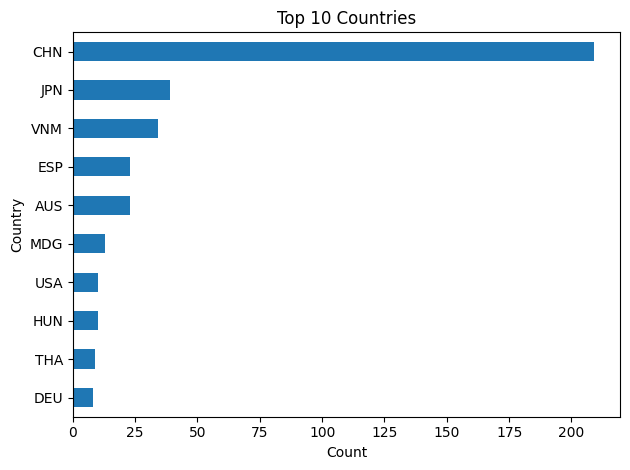

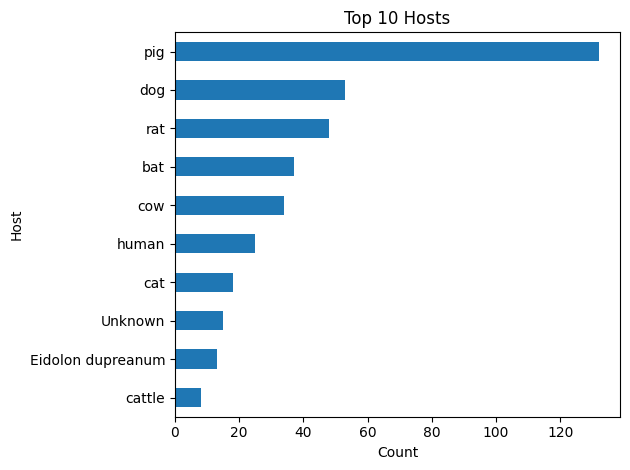

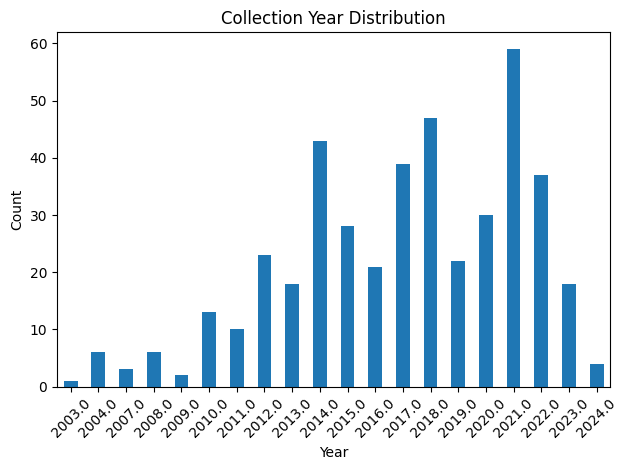

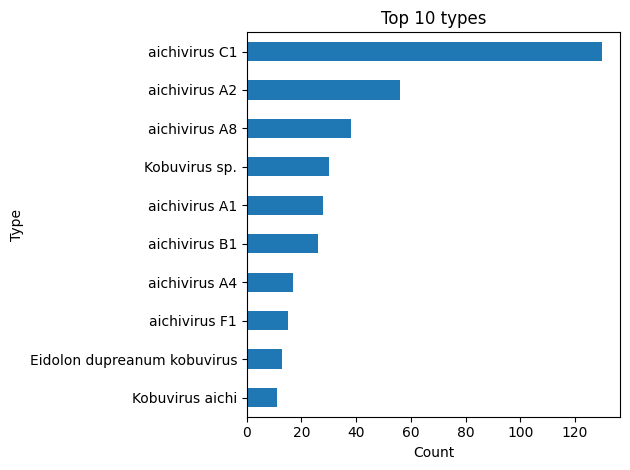

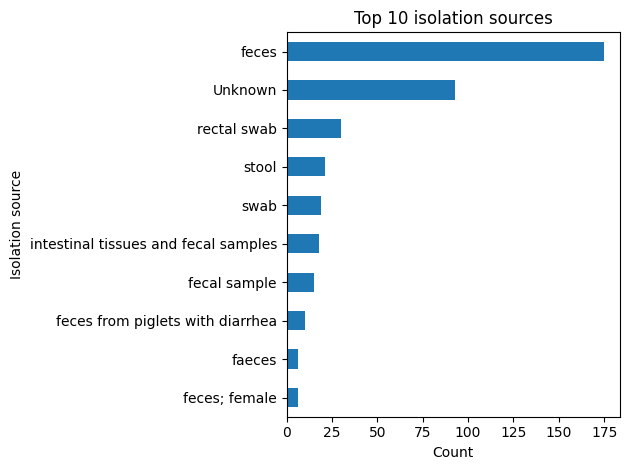

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../metadata_mapped_and_filtered.csv")

df["Year"] = pd.to_datetime(df["CollectionDate"], errors="coerce").dt.year

country_counts = df["Country"].value_counts().head(10)

plt.figure()
country_counts.sort_values().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Country")
plt.title("Top 10 Countries")
plt.tight_layout()
plt.show()


host_counts = df["Host"].value_counts().head(10)

plt.figure()
host_counts.sort_values().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Host")
plt.title("Top 10 Hosts")
plt.tight_layout()
plt.show()

year_counts = df["Year"].value_counts().sort_index()

plt.figure()
year_counts.plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Collection Year Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

type_counts = df['Serotype'].value_counts().head(10)

plt.figure()
type_counts.sort_values().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Type")
plt.title("Top 10 types")
plt.tight_layout()
plt.show()

iso_source_counts = df['IsolationSource'].value_counts().head(10)

plt.figure()
iso_source_counts.sort_values().plot(kind="barh")
plt.xlabel("Count")
plt.ylabel("Isolation source")
plt.title("Top 10 isolation sources")
plt.tight_layout()
plt.show()
